# Explore Redshift

In [1]:
!pip install -q SQLAlchemy==1.3.13

You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
from sqlalchemy import create_engine
import pandas as pd

# Settings
redshift_username = 'dsoaws'
redshift_pw = '<password>'
redshift_host = '<host>'
redshift_database = 'dsoaws'
redshift_port = '5439'
table_name = 'amazon_reviews_tsv'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(redshift_username, redshift_pw, redshift_host, redshift_port, redshift_database))


In [6]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'


In [7]:
df = pd.read_sql_query('SELECT product_category, \
                    COUNT(star_rating) AS count_star_rating \
                FROM {} \
                GROUP BY product_category \
                ORDER BY count_star_rating DESC'.format(table_name), engine)

In [8]:
df.head()

,product_category,count_star_rating
0,Books,18733577
1,Digital_Ebook_Purchase,16896025
2,Wireless,8130232
3,PC,6383124
4,Home,5700362


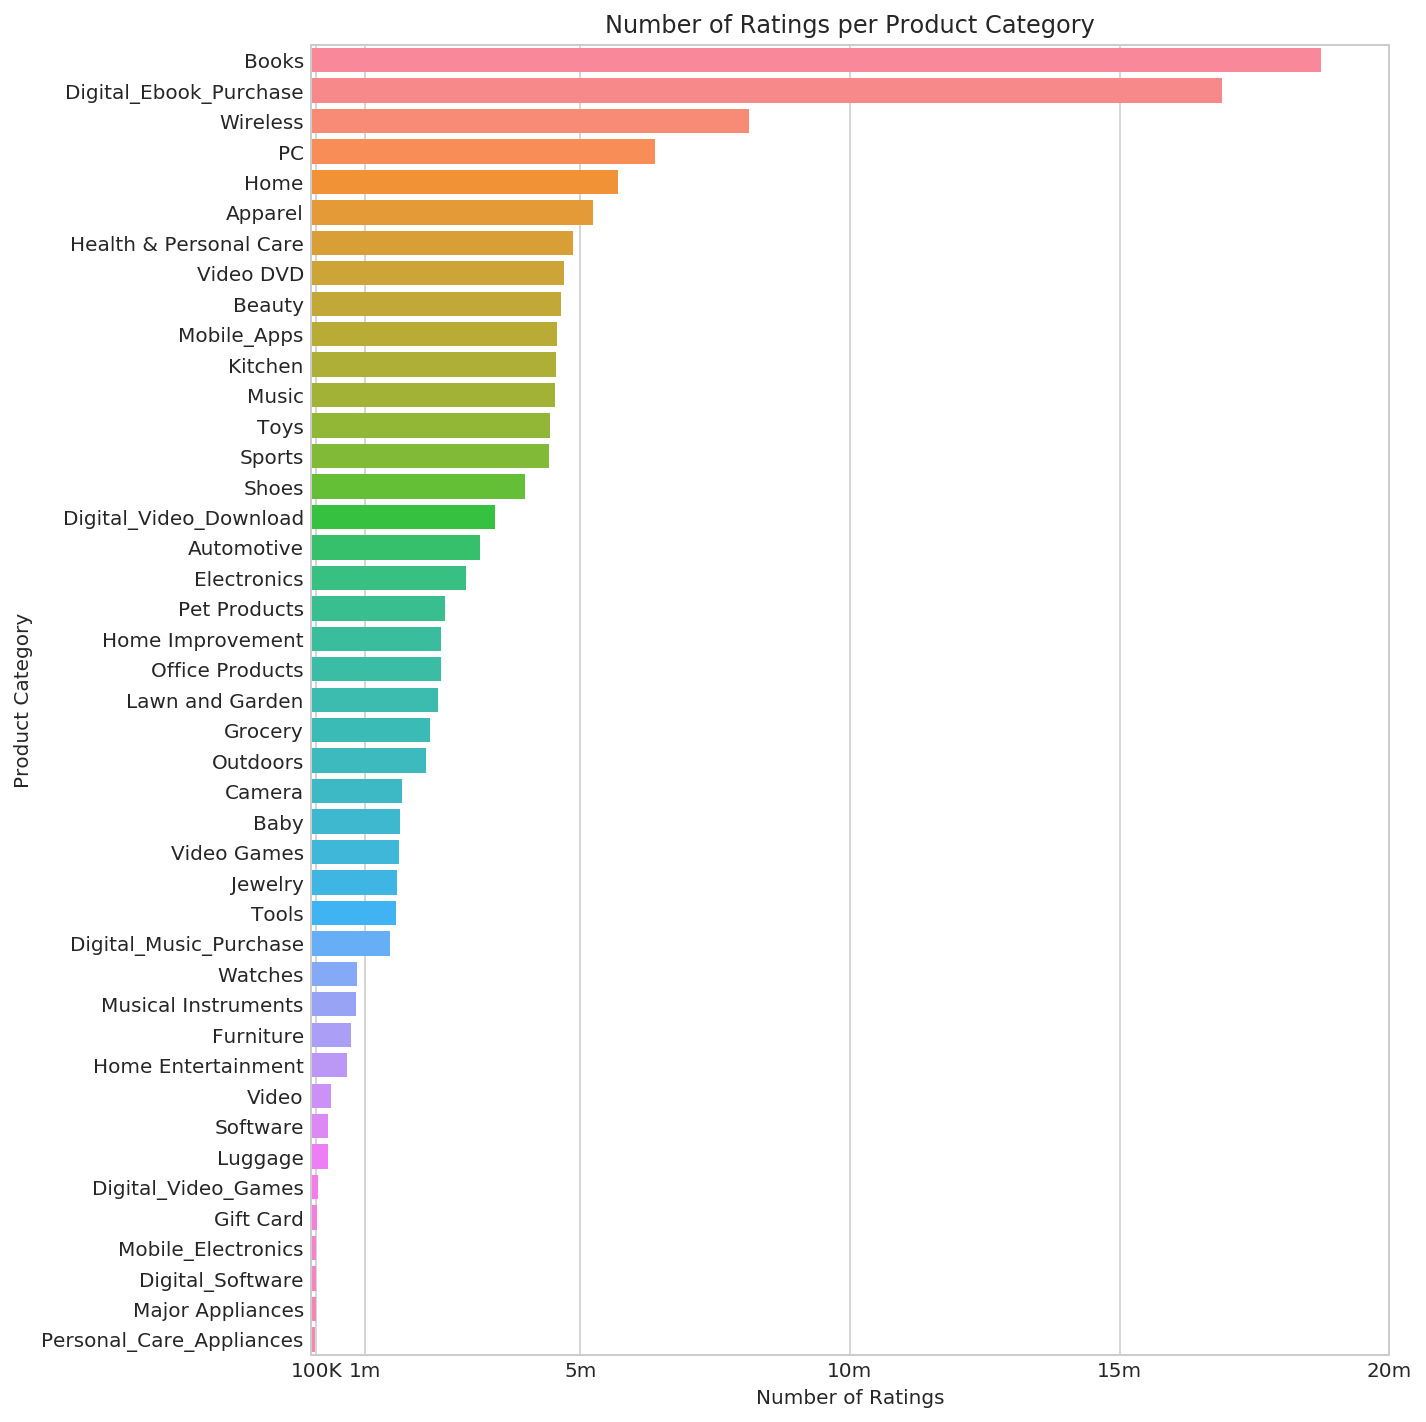

In [9]:
# Set size and style to use
plt.figure(figsize=(10,10))
plt.style.use('seaborn-whitegrid')

# Create Seaborn barplot
barplot = sns.barplot(y='product_category', x='count_star_rating', data = df, saturation=1)

# Set title
plt.title("Number of Ratings per Product Category")

# Set x-axis ticks to match scale from 10mio reviews to 20mio reviews
plt.xticks([100000, 1000000, 5000000, 10000000, 15000000, 20000000], ['100K', '1m', '5m', '10m','15m','20m'])
plt.xlim(0, 20000000)
plt.xlabel("Number of Ratings")
plt.ylabel("Product Category")

plt.tight_layout()

# Export plot if needed
# plt.savefig('ratings_per_category.png', dpi=300)

# Show the barplot
plt.show(barplot)